<a href="https://colab.research.google.com/github/Chirox03/Dogs-vs-Cat-classification/blob/main/DogvsCatVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

In [ ]:
!unzip /content/drive/MyDrive/DogvsCat/dog-vs-cat-classification.zip

In [ ]:
split=0.2
seed=19260817
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '/content/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '/content/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


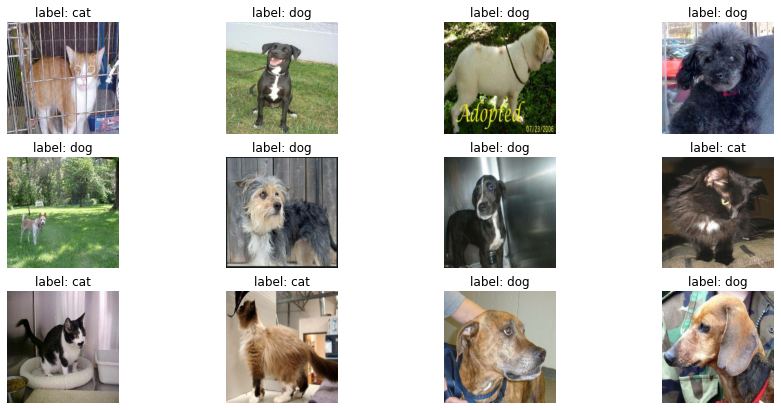

In [ ]:
label_names={0:'cat',1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+label_names[label.numpy()[i]])
        #rint("label:", label.numpy()[i])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

In [ ]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

In [ ]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        #layers.RandomTranslation(0.14,0.14),
        #layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [ ]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/40
79/79 [==============================] - 303s 3s/step - loss: 189.5260 - accuracy: 0.9010 - val_loss: 64.2705 - val_accuracy: 0.9740
Epoch 2/40
79/79 [==============================] - 239s 3s/step - loss: 115.3826 - accuracy: 0.9421 - val_loss: 22.5335 - val_accuracy: 0.9826
Epoch 3/40
79/79 [==============================] - 238s 3s/step - loss: 57.2055 - accuracy: 0.9469 - val_loss: 12.4112 - val_accuracy: 0.9834
Epoch 4/40
79/79 [==============================] - 237s 3s/step - loss: 22.8936 - accuracy: 0.9527 - val_loss: 5.5407 - val_accuracy: 0.9846
Epoch 5/40
79/79 [==============================] - 238s 3s/step - loss: 11.7610 - accuracy: 0.9582 - val_loss: 4.0283 - val_accuracy: 0.9826
Epoch 6/40
79/79 [==============================] - 238s 3s/step - loss: 7.7421 - accuracy: 0.9609 - val_loss: 4.1197 - val_accuracy: 0.9838
Epoch 7/40
79/79 [==============================] - 238s 3s/step - loss: 6.8445 - accuracy: 0.9617 - val_loss: 3.1305 - val_accuracy: 0.9838
Epo

In [ ]:
import os
test_filenames = os.listdir("/content/test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

8000

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


In [ ]:
predict = vgg16_model.predict(test_generator)
test_df['labels'] = np.argmax(predict, axis=-1)

In [ ]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)